# Set Up and Data Processing

In [25]:
from capstone import data
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [26]:
torch.cuda.empty_cache()

In [27]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [28]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [29]:
# take 5% of data with a different seed
train_df, valid_df = data.data_processing(path, 'Atelectasis', 58, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(10581, 2)

Validation shape
(234, 2)


In [30]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00019/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00019/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00019/study4/...,1.0
3,CheXpert-v1.0-small/train/patient00019/study3/...,1.0
4,CheXpert-v1.0-small/train/patient00019/study2/...,-1.0


In [31]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# _U-Ignore_: Drop Uncertain (-1) Labels

In [32]:
train_df = train_df[train_df['Atelectasis'] != -1].reset_index(drop=True)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [33]:
train_df.head(10)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00019/study1/...,0
1,CheXpert-v1.0-small/train/patient00019/study1/...,0
2,CheXpert-v1.0-small/train/patient00019/study4/...,1
3,CheXpert-v1.0-small/train/patient00019/study3/...,1
4,CheXpert-v1.0-small/train/patient00030/study1/...,0
5,CheXpert-v1.0-small/train/patient00056/study1/...,1
6,CheXpert-v1.0-small/train/patient00056/study1/...,1
7,CheXpert-v1.0-small/train/patient00056/study4/...,0
8,CheXpert-v1.0-small/train/patient00056/study3/...,0
9,CheXpert-v1.0-small/train/patient00059/study1/...,0


In [34]:
train_df.shape

(9112, 2)

# Set Up For DL Training

In [35]:
tfms = get_transforms(do_flip=False, flip_vert=False)

In [36]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [37]:
src = src.split_by_rand_pct(0.1)

In [38]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 7048MB of GPU RAM free


In [39]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [40]:
data.c

2

In [41]:
data.classes

[0, 1]

In [52]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [53]:
learn11 = cnn_learner(data=data, base_arch=models.densenet121, metrics=accuracy, pretrained=True, callback_fns=AUROC)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.48E-06
Min loss divided by 10: 1.35E-03


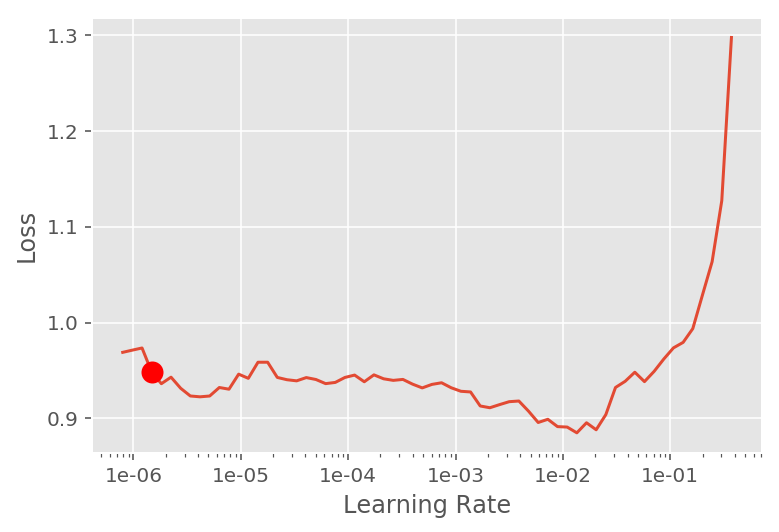

In [54]:
learn11.lr_find(start_lr=1e-7, end_lr=100)
learn11.recorder.plot(suggestion=True)

In [55]:
lr = (1e-03 + 1e-02) / 2
lr

0.0055

# Rd. 1 Training

In [56]:
learn11.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.515652,0.464964,0.830955,0.521331,03:10
1,0.519317,0.456623,0.841932,0.511462,03:09
2,0.498431,0.450057,0.841932,0.558534,03:09
3,0.484280,0.434915,0.841932,0.565877,03:08
4,0.460515,0.443797,0.841932,0.570169,03:08


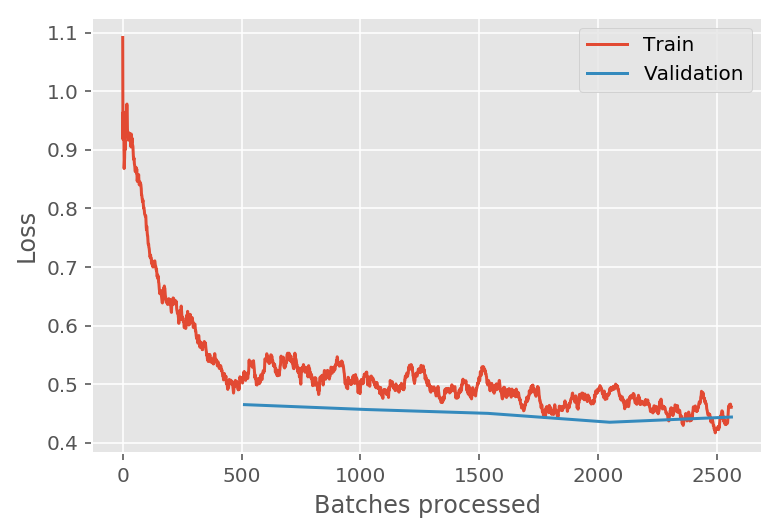

In [57]:
learn11.recorder.plot_losses()

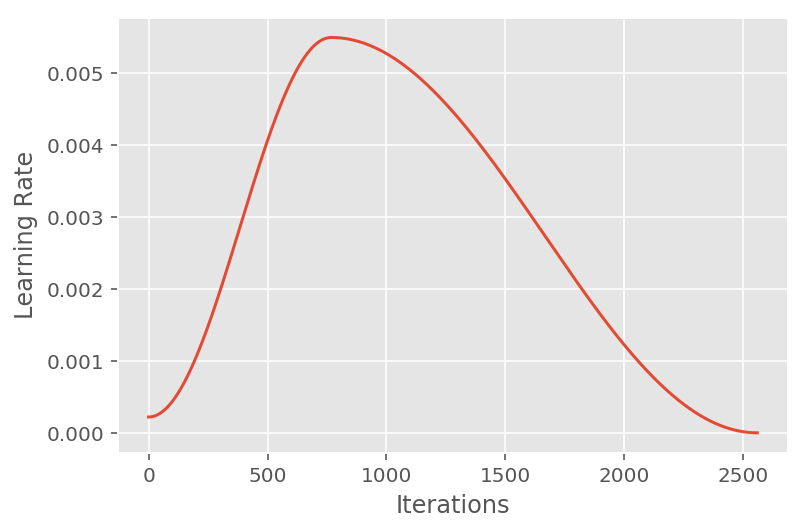

In [59]:
learn11.recorder.plot_lr()

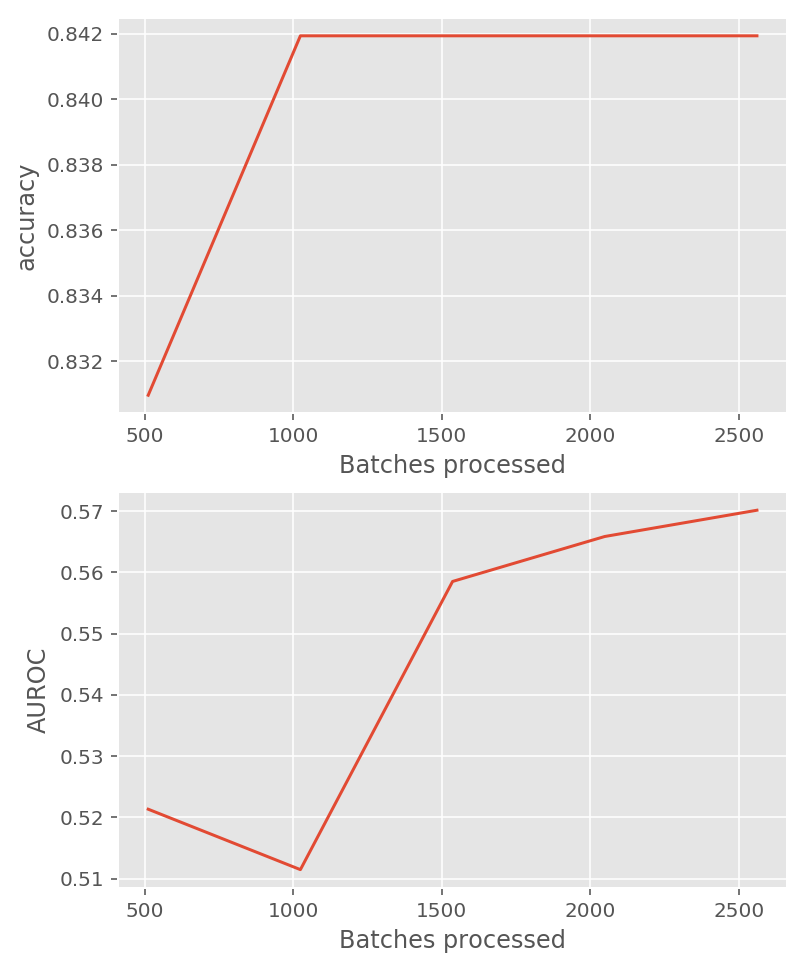

In [60]:
learn11.recorder.plot_metrics()

In [61]:
learn11.save('learn11-rd-1-rn121')

# Rd. 2 Training

In [62]:
# fine-tune whole model
learn11.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.82E-06
Min loss divided by 10: 2.51E-03


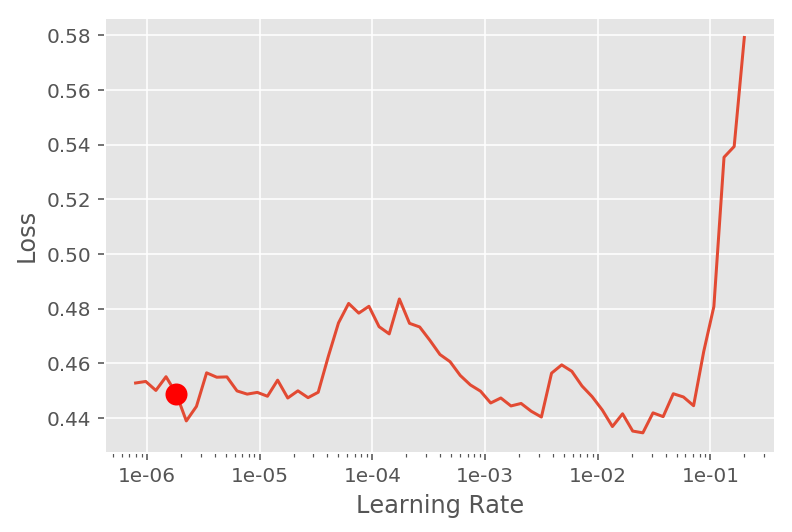

In [63]:
learn11.lr_find(start_lr=1e-7, end_lr=100)
learn11.recorder.plot(suggestion=True)

In [66]:
x = (1e-04 + 1e-03) / 2
learn11.fit_one_cycle(5, slice(x))

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.461195,0.432987,0.841932,0.575040,04:06
1,0.481112,0.443503,0.839737,0.558245,04:06
2,0.473623,0.543663,0.835346,0.547968,04:06
3,0.442693,0.603378,0.829857,0.562962,04:06
4,0.463157,0.456179,0.840834,0.579766,04:06
